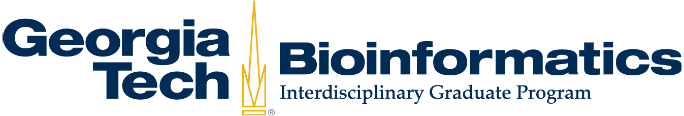

<div class="alert alert-block alert-info">
    <h1>BIOS 4150/BIOL 6150</h1>
    <h3>Instructor: Dr. King Jordan</h3>
    <p>TAs: Shivam Sharma (shivamsharma13@gatech.edu) & Vishva Natarajan (vishvanata@gatech.edu)</p>
</div>

<div class="alert alert-block alert-warning">
    <h3>Project 7: <i>Introduction to single cell gene expression analysis</i></h3>
    <h4>Deadline: 5:30PM, December 13th, 2023</h4>
    <h4>Total Points: 300</h4>
    
</div>

<div class="alert alert-block alert-danger">
    <h3>Alert!</h3>
    <p>Do not delete any comments or information boxes the starter notebook comes with</p>
</div>

<div class="alert alert-block alert-info">
    <h2>Please folow the following guidelines:</h2>
    <p>1. You can use PACE RStudio for this project, but please bring this analysis code to the jupyter notebook for submission. (Write your R code in the cells of this notebook with appropriate comments).</p>
    <p>2. Figures are the most important aspect of this project, so please download (from PACE RStudio) and show you result figures in this jupyter notebook using markdown.</p>
    <p>3. This project will focus on a simple analysis of a single cell gene expression dataset. The sections are divided broadly, so please explain your work in as much detail as possible.</p>
</div>

---

# **1. Reading the data**
### *Total Questions: 1*
### *Total Points: 50*


---

<div class="alert alert-block alert-warning">
    <h3>1. Locate and read the data</h3>
    <p>We have raw data files in: /storage/ice-shared/biol6150/Data/SingleCell/ProjectDataset/. Read this data using Seurat and get ready for QC</p> 
</div>

In [3]:
### Add cells for R code, comments and figures (using markdown) to keep in mind.
#Road required packages
library(dplyr)
library(Seurat)
library(patchwork)
install.packages("hdf5r")
library("hdf5r")


### Accessing the data.

# Load the dataset
#In this case, we'll use Read10X_h5 function from Seurat package.
pbmc.data <- Read10X_h5("/Users/yusakunitta/biol6150/Project7/10k_PBMC_3p_nextgem_Chromium_X_intron_raw_feature_bc_matrix.h5")
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc

# Lets examine a few genes in the first thirty cells
pbmc.data[c("OR4F5", "MIR1302-2HG", "AL627309.2"), 1:30]

#2,299,294 single cells that were sequenced on the Illumina NextSeq 500
dim(pbmc.data)
head(pbmc.data)

######################
### Quality Control###
######################

# add "percent.mt" to object metadata with '[[' operators.
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

# Show QC metrics for the first 5 cells
head(pbmc@meta.data, 5)

In [ ]:
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

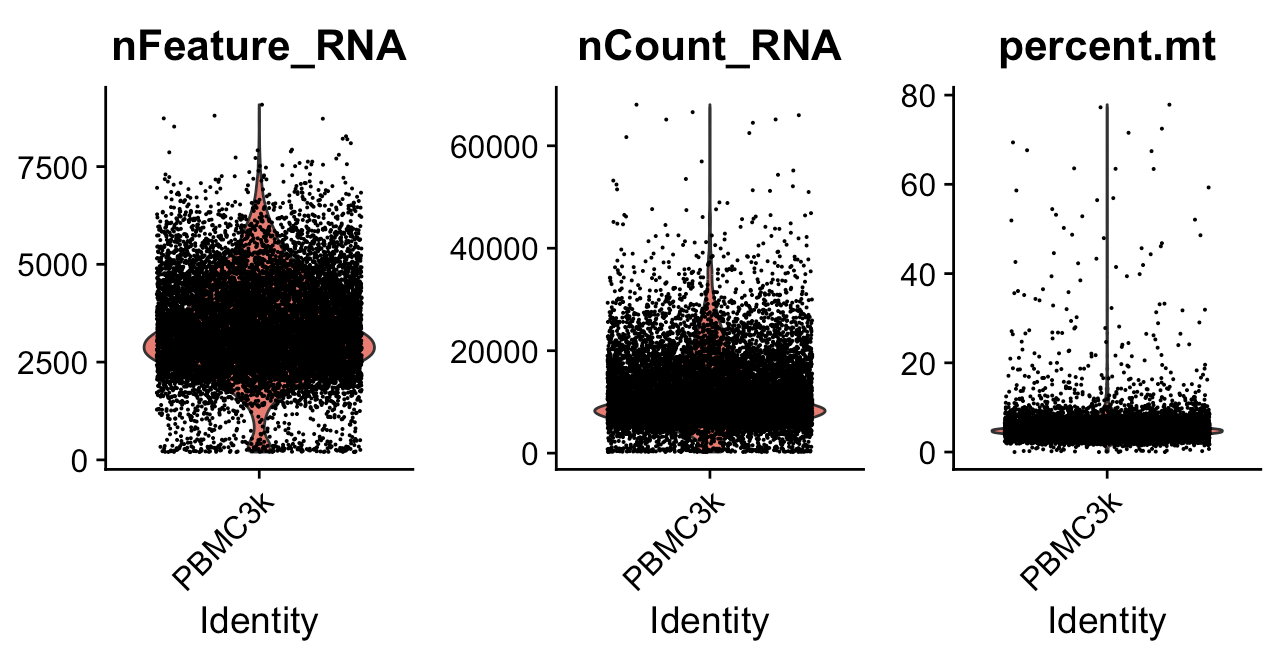

# Use FeatureScatter to visualize feature-feature relationships of our pbmc data 
## Figure on the left: relationships between mitochondrial counts and RNA counts.
## Figure on the right: relationships between RNA feature counts and RNA counts.

In [ ]:
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

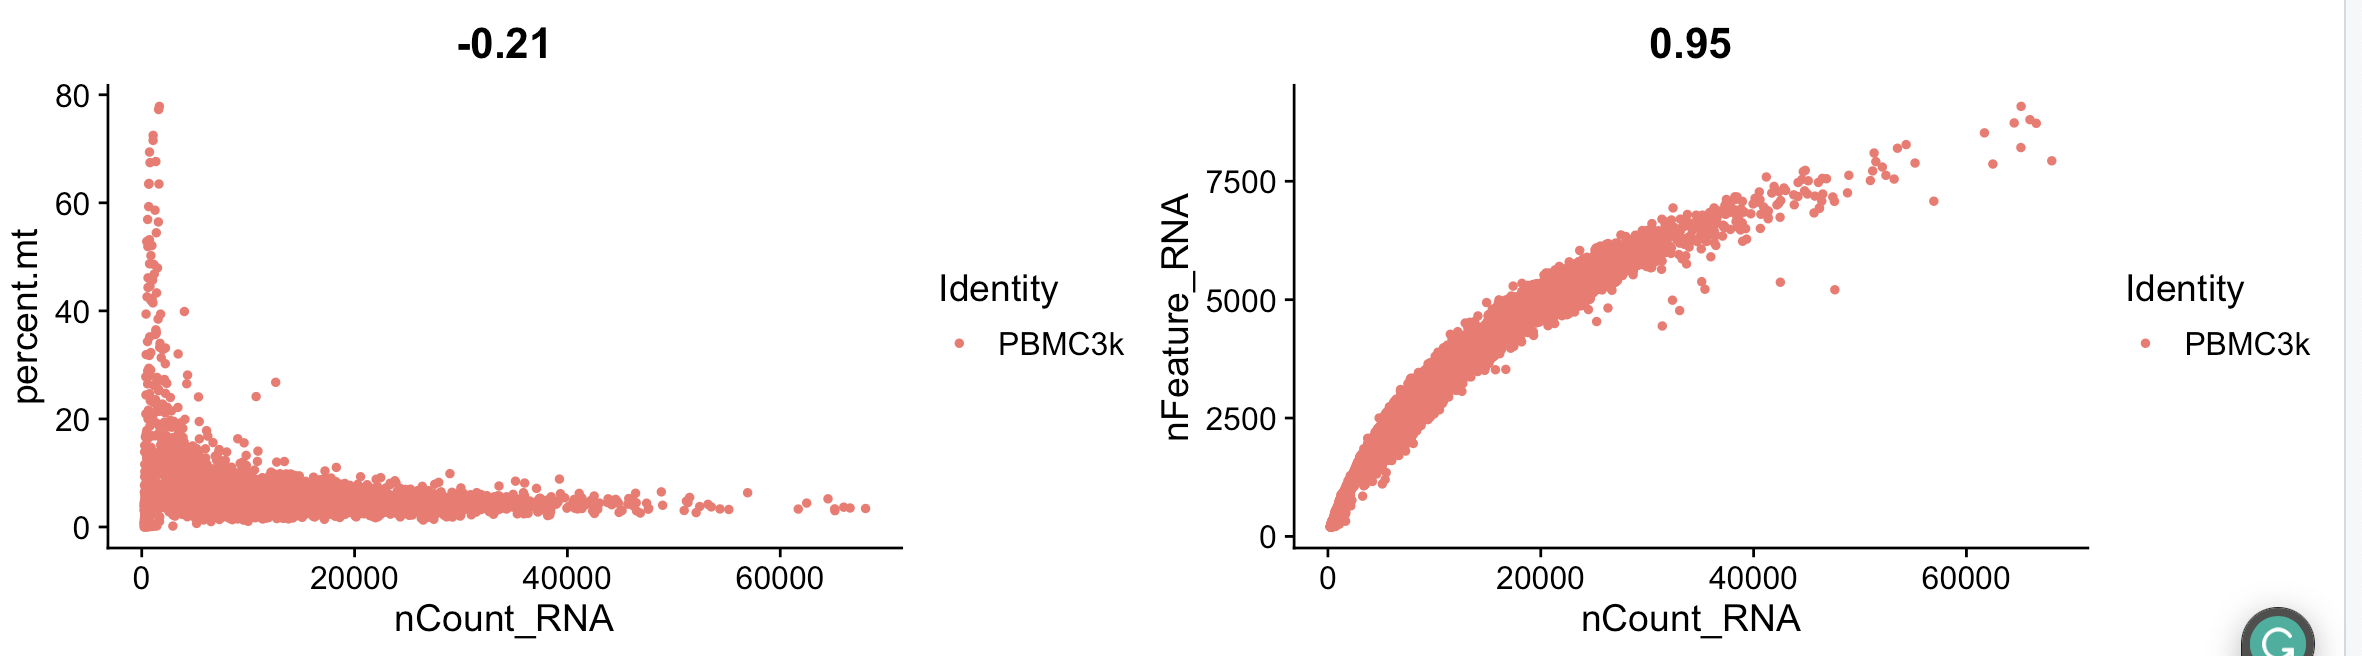

#### As you may notice, scatter plots indicate two findings:

#### 1: There is no noticeable relationship between mitochondrial counts and RNA counts.
#### 2: There is a clear positive correlation between RNA feature counts and RNA counts. 

# **2. Quality control**
### *Total Questions: 1*
### *Total Points: 100*


---

<div class="alert alert-block alert-warning">
    <h3>2. QC and normalization</h3>
    <p>Perform QC, normalization and feature selection on this dataset. Show your feature selection scatter plot in this notebook (and any other figures you create along the way)</p>
</div>

In [14]:
### Add cells for R code, comments and figures (using markdown) to keep in mind.

## 2 filters for QC:
# 1. filter cells that have unique feature counts over 2,500 or less than 200
# 2. filter cells that have >5% mitochondrial counts

# Pruning (trimming process for QC)
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

### Normalization
# normalize the feature expression measurements for each cell by the total expression. 
# multiply the measurements by a scale factor (10,000 by default), and log-transforms the result. 

pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

### Feature selection
# highly expressed in some cells, and lowly expressed in others
# models on mean-variance relationship inherent in single-cell data
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

In [ ]:
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

##  Figure on the left: a plot of variable features of genes 
##  Figure on the right: a plot of variable features with 10 annotated genes that are most highlt variable
### We annotated the following genes as top 10 most highly variable genes: S100A9, S100A8, GNLY, IGKC, LYZ, NKG7, IGHM, VCAN, HLA-DRA, CCL5. These genes show significant variability in their expression levels across individual cells.

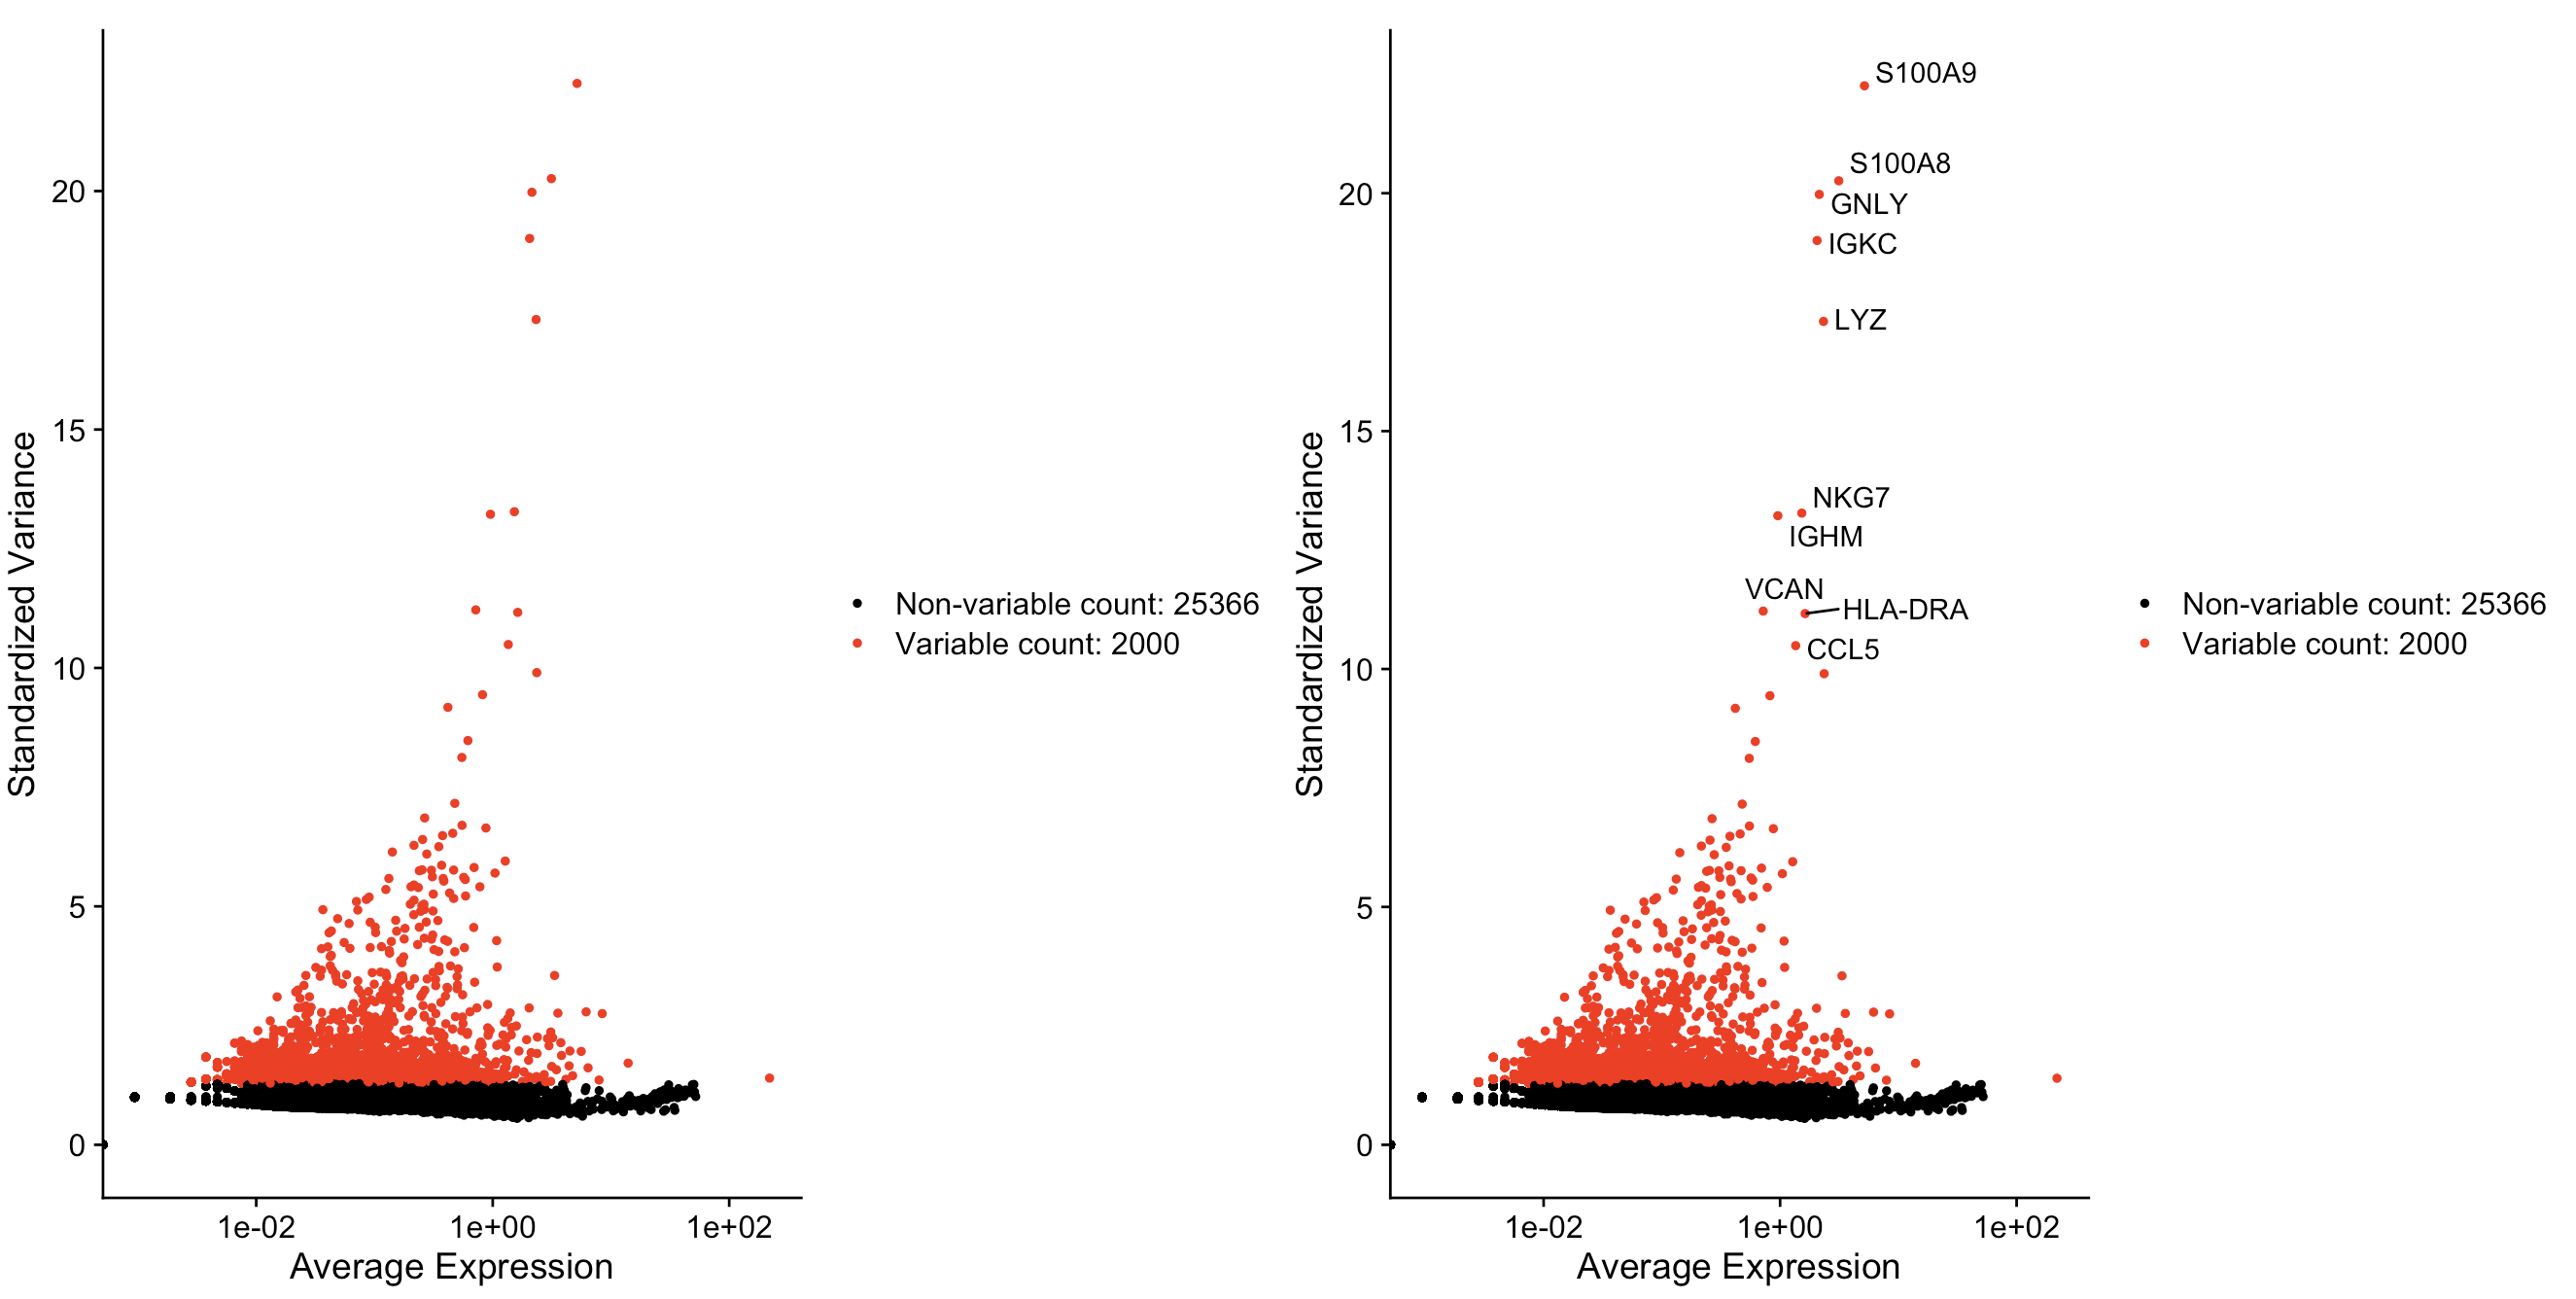

# **3. Dimensionality reduction and clustering**
### *Total Questions: 2*
### *Total Points:  50+50 = 100*


---

<div class="alert alert-block alert-warning">
    <h3>3.1 Can you see any clusters in your data?</h3>
    <p>1. Plot your PCA</p>
    <p>1. Plot your UMAP</p>
</div>

In [6]:
### Add cells for R code, comments and figures (using markdown) to keep in mind.

### Scaling the data. (linear transformation)
# Shifts the expression of each gene, so that the mean expression across cells is 0
# Scales the expression of each gene, so that the variance across cells is 1
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

In [ ]:
####################
##### PCA plot #####
####################

pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

#Check if cells cluster in PCA
DimPlot(pbmc, reduction = "pca") + NoLegend()

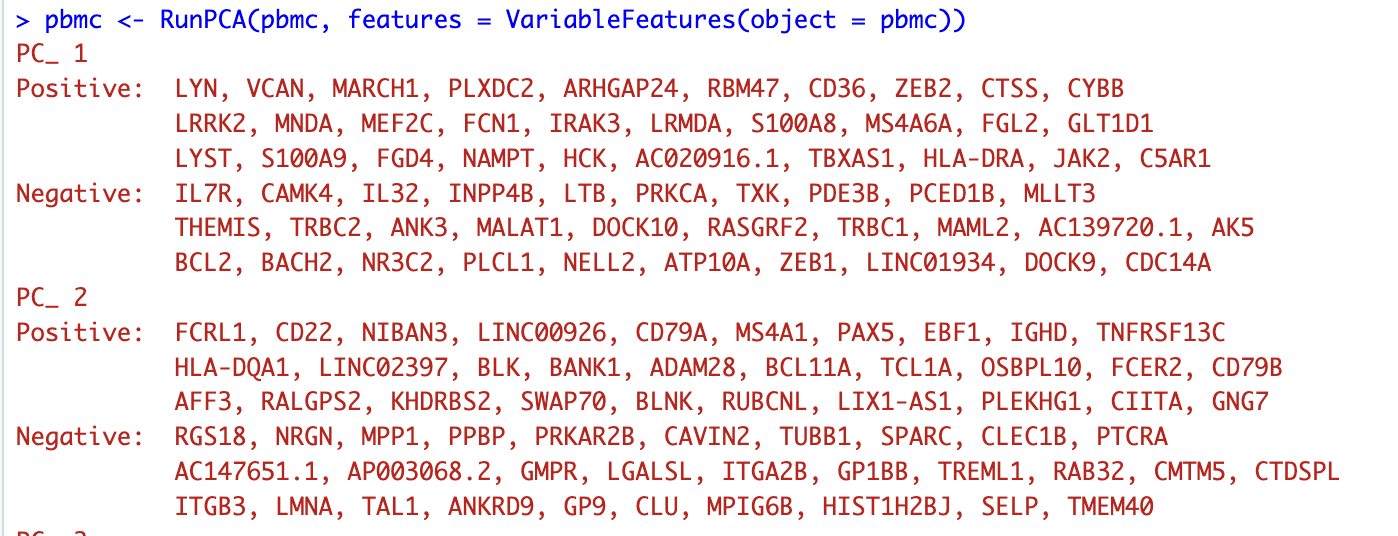

### The figure does not explicitly display clusters as all the data points are color-coded the same. 

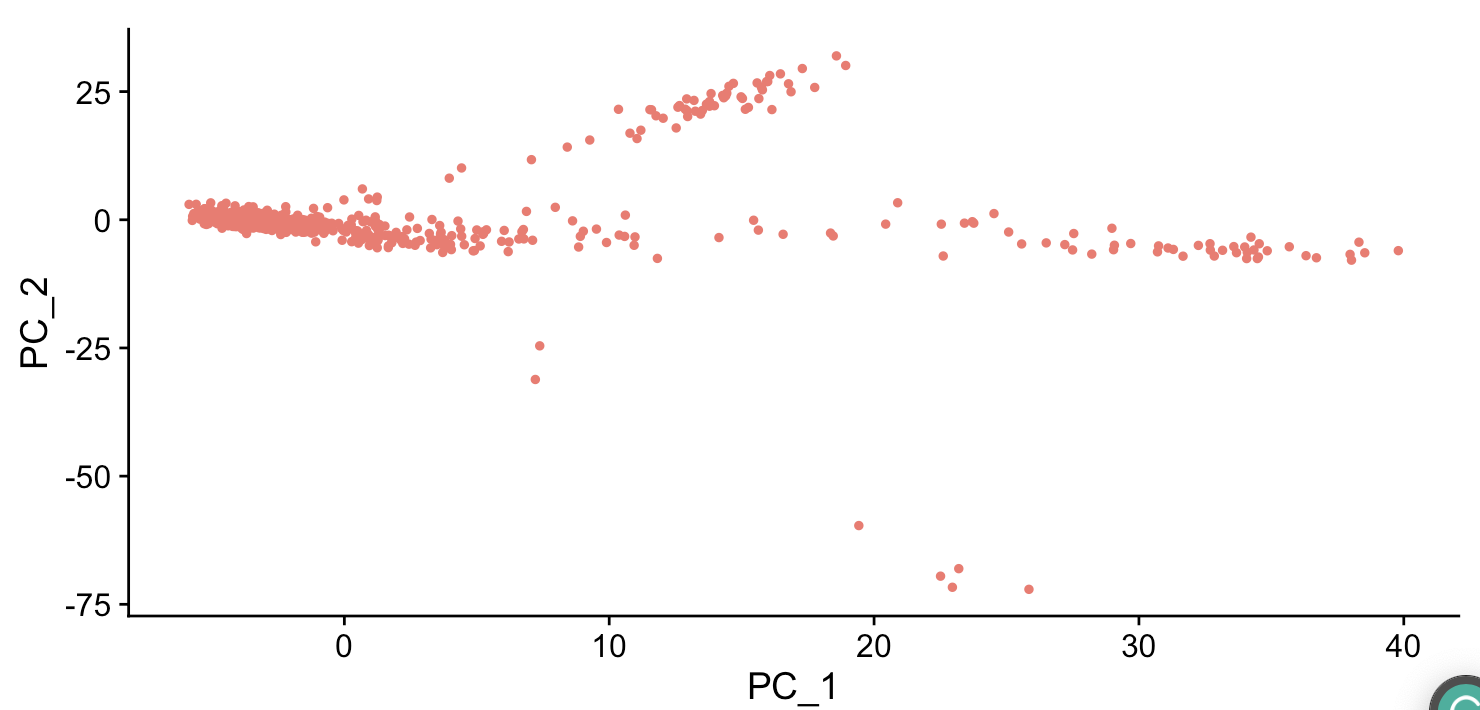

In [ ]:
####################
#### UMAP plot #####
####################

#generate a Uniform Manifold Approximation and Projection (UMAP)
pbmc <- RunUMAP(pbmc, dims = 1:10)
DimPlot(pbmc, reduction = "umap")

### Just like the PCA, UMAP plot does not explicitly display clusters as all the data points are color-coded the same. 

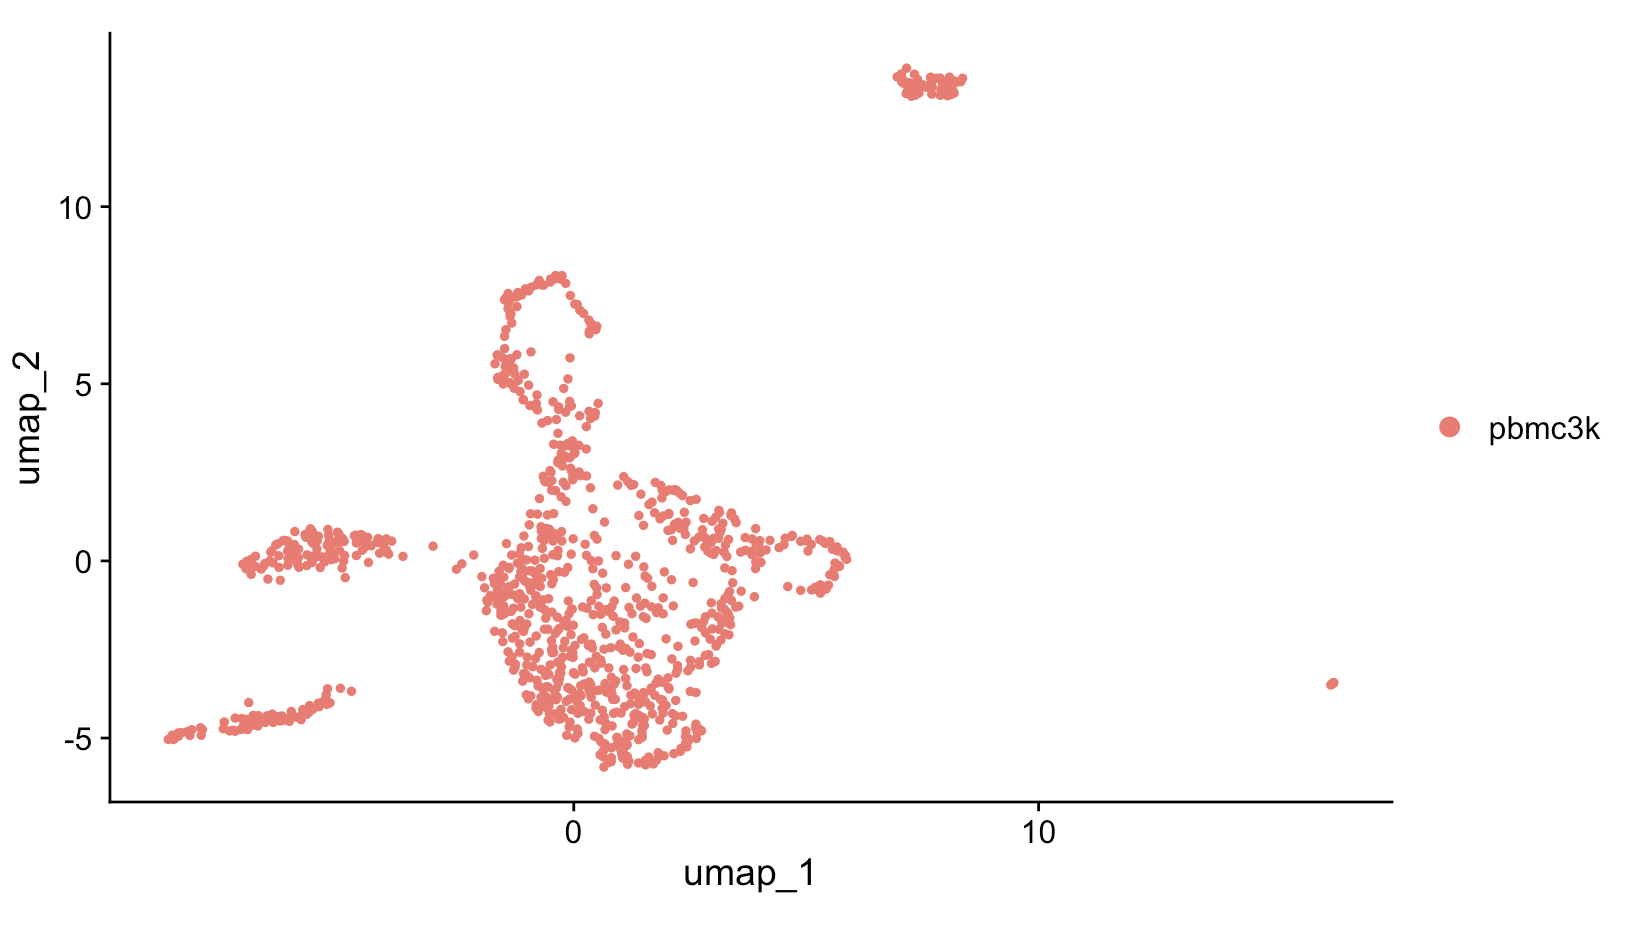

<div class="alert alert-block alert-warning">
    <h3>3.2 Perform clustering of cells using graph based clustering approach as implemented in Seurat's tutorial.</h3>
    <p>1. Plot your PCA (show clusters this time)</p>
    <p>1. Plot your UMAP (show clusters this time)</p>
</div>

In [ ]:
### Add cells for R code, comments and figures (using markdown) to keep in mind.

In [ ]:
# Clustering using a graph based approach: KNN-graph.
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

In [ ]:
####################
##### PCA plot #####
####################
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

#Check if cells cluster in PCA?
DimPlot(pbmc, reduction = "pca") + NoLegend()

### After clustering, we identified 8 different cell types, which are color-coded accordingly.
### Looking at a PCA plot, 3-4 cell types are overlapping at the upperleft region. 

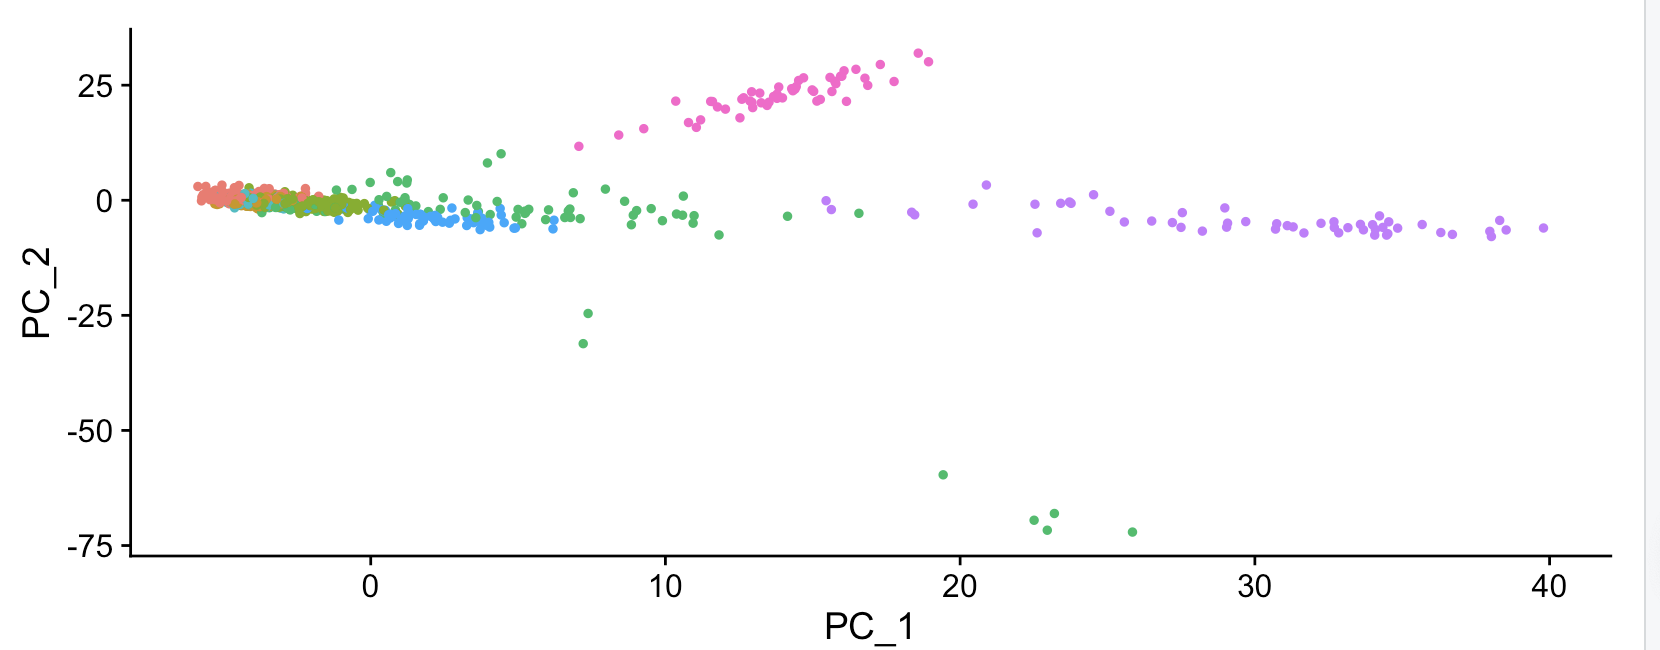

In [ ]:
pbmc <- RunUMAP(pbmc, dims = 1:10)
DimPlot(pbmc, reduction = "umap")

### Looking at a UMAP plot, each of 8 cell types exhibit unique clutering patterns.

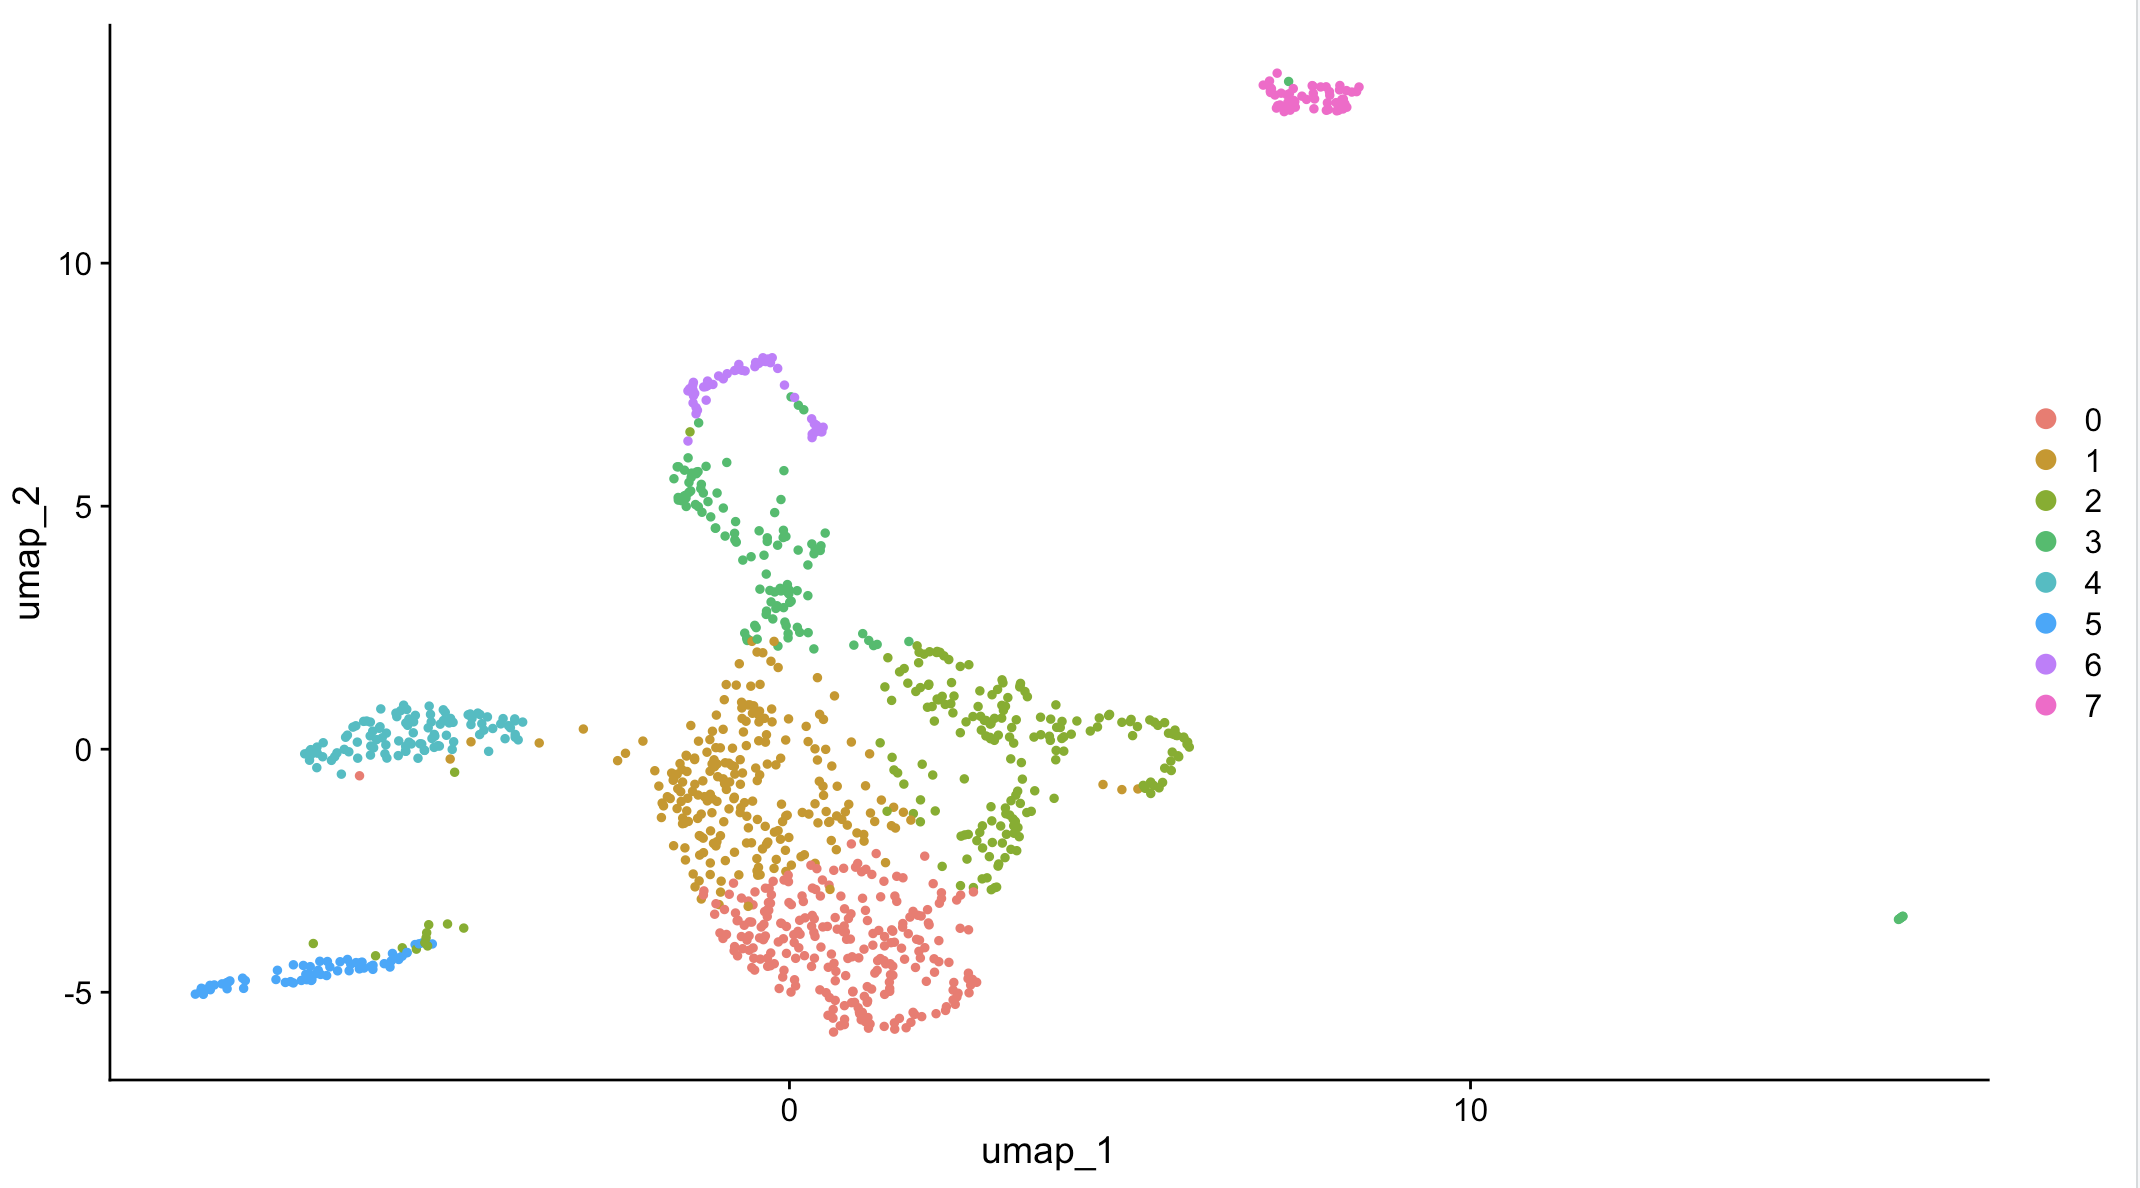

# **4. Identify specific genes**
### *Total Questions: 1*
### *Total Points: 50*


---

<div class="alert alert-block alert-warning">
    <h3>4. Identify highly variable genes</h3>
    <p>For these highly variable genes (select 3-4 genes), investigate if gene expression values are variable between identified clusters (plot (RStudio) and show violin plots here) </p>
</div>

In [ ]:
### Add cells for R code, comments and figures (using markdown) to keep in mind.

### Markers specific to each cluster.
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3))
head(cluster5.markers, n = 5)

# find markers for every cluster compared to all remaining cells, report only the significant ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE)
pbmc.markers %>%
  group_by(cluster) %>%
  dplyr::filter(avg_log2FC > 1)

# Select four gene from top 10 highly variable genes of section 2. 
VlnPlot(pbmc, features = c("S100A9", "S100A8", "GNLY", "LYZ"), slot = "counts", log = TRUE)

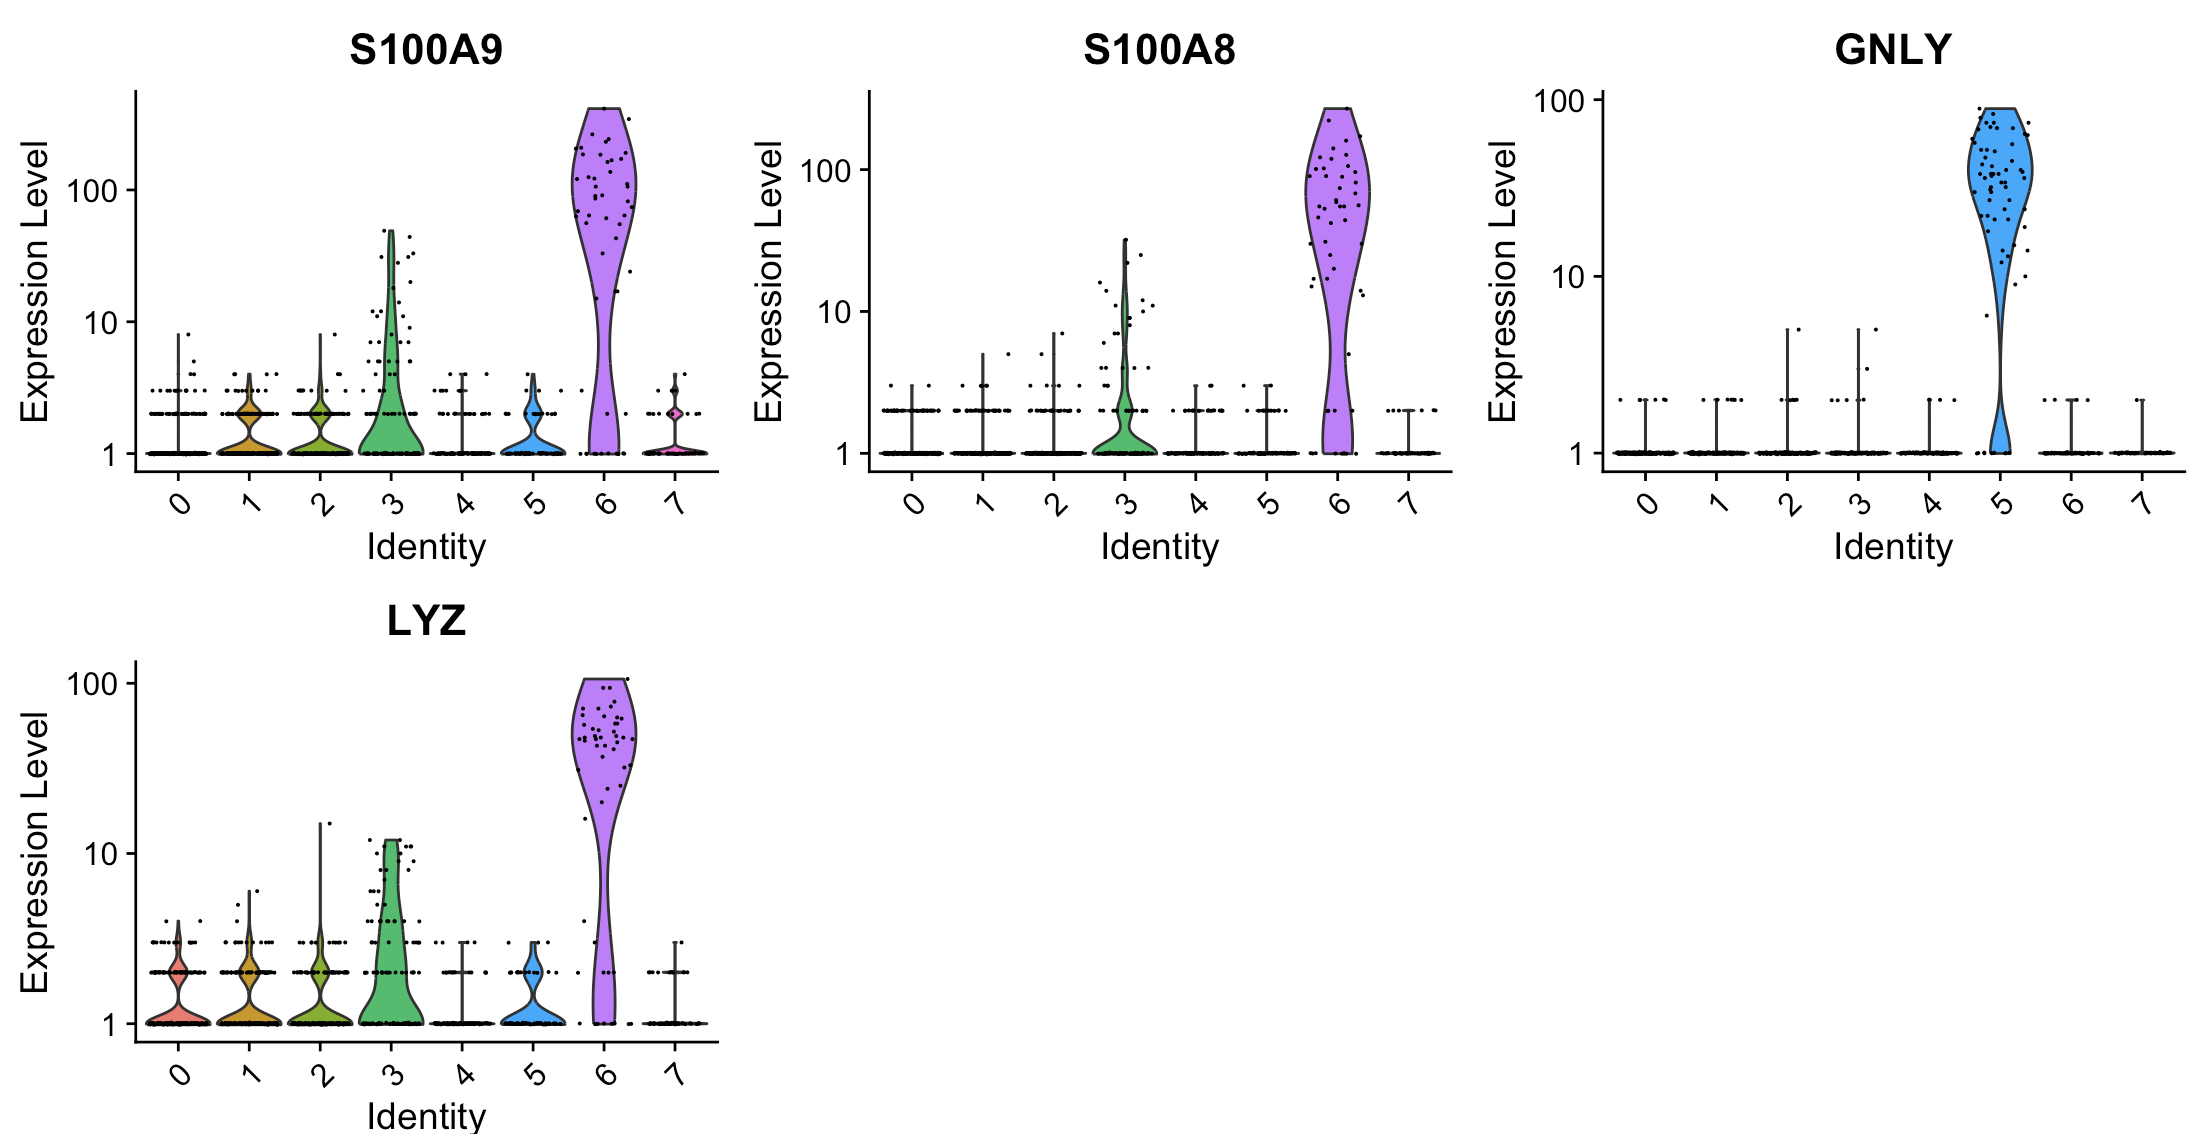

### Each figure is a violin plot that shows expression levels across 8 different cell types of the four genes of our choice: "S100A9", "S100A8", "GNLY", and "LYZ." All of them are from top 10 genes that are most highly variable genes in terms of gene expression levels across cell types.

### As you can see, each gene is explicitly expressed in one cell type than the other cell types, which corrresponds with the fact that the genes are among the most highly variable. 

### 3 out of the four genes ("S100A9", "S100A8," and "LYZ") showed the same expression pattern, having the highest expression level in cell type6 and noticeable degree of expression level in cell type 3. Interestingly, GNLY gene exhibited an extremely high expression level in cell type 5 and little to no expression level in all the other cell types. 